In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
from PIL import Image
from scipy import ndimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import pytorch_lightning as pl

%matplotlib inline
np.random.seed(1)

In [2]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])    
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    imgs = np.transpose(imgs, (0, 3, 1, 2))
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1080, 3, 64, 64) (1080,)
(120, 3, 64, 64) (120,)


In [3]:
type(train_x[0][0])

numpy.ndarray

In [4]:
import timm

#timm.list_models(filter="efficient*")#

In [5]:
# CONSTANTS
class Config:
    NUM_FOLDS = 5
    NUM_CLASSES = 6
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    NUM_EPOCHS = 10
    TRAIN_IMG_MEAN = [0.485, 0.456, 0.406]
    TRAIN_IMG_STD = [0.229, 0.224, 0.225]
    UNFREEZE_EPOCH_NO = 2
    PRECISION = 16
    PATIENCE = 5

class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"

In [6]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=Config.NUM_FOLDS, X=train_x, y=train_y)

In [7]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform, target_transform, 
                transform_type=TransformationType.TORCHVISION):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform
        self.target_transform = target_transform
        self.transform_type = transform_type

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        tfmd_img = self.img_arr[index]
        tfmd_img = tfmd_img.transpose(1,2,0)
        #print(type(tfmd_img), tfmd_img.shape)
        tfmd_label = self.label_arr[index]
        if self.transform:
            if self.transform_type == TransformationType.TORCHVISION:                        
                tfmd_img = self.transform(tfmd_img)
            elif self.transform_type == TransformationType.ALB:
                augmented = self.transform(image=tfmd_img)
                tfmd_img = augmented["image"]                   
        if self.target_transform:               
            tfmd_label = self.target_transform(tfmd_label)              
        return tfmd_img, tfmd_label            

In [8]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(Config.TRAIN_IMG_MEAN, Config.TRAIN_IMG_STD)])

# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):
    fold += 1                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train = NpArrayImageDataset(train_X, train_y, transform=img_transforms, target_transform=torch.as_tensor)
    ds_val = NpArrayImageDataset(val_X, val_y, transform=img_transforms, target_transform=torch.as_tensor)
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [9]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]            
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

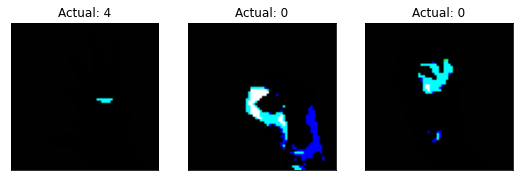

In [10]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)
#len(ds_val)
show_batch(ds_val, 3, 1, 3)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import timm

class ImageClassificationModel(nn.Module):
    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def __init__(self, num_classes, drop_out=0.25, model_to_use="resnext"):
        super().__init__()                
        self.num_classes = num_classes        
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, drop_out, num_classes)    

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

In [12]:
import torchmetrics
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy

class ImageClassificationLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        self.lr = hparams["lr"]
        self.num_classes = num_classes        
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):
        model_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min")        
        return {
            "optimizer": model_optimizer, 
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
                "frequency": 1
            }
        }

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_acc = accuracy(y_pred, y)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return {"loss": val_loss, "val_acc": val_acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        X, y = batch
        # this calls forward
        return self(X)

    def on_train_end(self):
        return super().on_train_end()        

In [13]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(42, workers=True)

# model hyperparameters
model_params = {    
    "drop_out": 0.25,
    "lr": 0.001
    }

Global seed set to 42


In [14]:
from optuna.integration import PyTorchLightningPruningCallback

def run_hparam_tuning(model_params, trial):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)    
    early_stopping = PyTorchLightningPruningCallback(trial, monitor="val_loss")
    backbone_finetuning_cb = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=False)
    signs_model = ImageClassificationLitModel(
        num_classes=Config.NUM_CLASSES, 
        hparams=model_params,        
        model_to_use=Models.RESNET50
        )  
    trainer = pl.Trainer(
        checkpoint_callback=False,        
        gpus=1,
        # For results reproducibility 
        deterministic=True,
        auto_select_gpus=True,
        progress_bar_refresh_rate=20,
        max_epochs=Config.NUM_EPOCHS,        
        precision=Config.PRECISION,   
        weights_summary=None,                     
        callbacks=[backbone_finetuning_cb, early_stopping]
    )      
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)     
    loss = trainer.callback_metrics["val_loss"].item()
    del trainer, signs_model, early_stopping, backbone_finetuning_cb, dl_train, dl_val
    return loss

In [15]:
# import optuna

# def objective(trial):
#     params = {
#         "lr": trial.suggest_loguniform("lr", 1e-6, 1e-3),
#         "drop_out": trial.suggest_uniform("drop_out", 0.2, 0.7)
#     }    
#     loss = run_hparam_tuning(params, trial)
#     return loss

# study = optuna.create_study(direction="minimize", study_name="SignsImageClassificationTuning")    
# study.optimize(objective, n_trials=10)
# print(f"Best trial number = {study.best_trial.number}")
# print("Best trial params:")
# print(study.best_params)

In [16]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

class MetricsAggCallback(Callback):
    def __init__(self, metric_to_monitor, mode):
        self.metric_to_monitor = metric_to_monitor
        self.metrics = []
        self.best_metric = None
        self.mode = mode
        self.best_metric_epoch = None

    def on_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        metric_value = trainer.callback_metrics[self.metric_to_monitor].item()
        print(f"metric {self.metric_to_monitor} = {metric_value}")
        self.metrics.append(trainer.callback_metrics[self.metric_to_monitor].item())
        if self.mode == "max":
            self.best_metric = max(self.metrics)
            self.best_metric_epoch = self.metrics.index(self.best_metric)
        

In [17]:
def run_training(fold, dl_train, dl_val, find_lr=True):
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        tb_logger = None
        chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)
        #print_table_metric_cb = PrintTableMetricsCallback()
        if fold is not None:       
            chkpt_file_name = fold_str + "_" + chkpt_file_name
            tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs", version=fold_str)
        else:
            tb_logger = pl.loggers.TensorBoardLogger(save_dir="logs")        
        signs_model = ImageClassificationLitModel(
            num_classes=Config.NUM_CLASSES, 
            hparams=model_params,        
            model_to_use=Models.RESNET50
            )    
        loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=chkpt_file_name)
        acc_chkpt_callback = MetricsAggCallback(metric_to_monitor="val_acc", mode="max")
        trainer = pl.Trainer(
            gpus=1,
            # For results reproducibility 
            deterministic=True,
            auto_select_gpus=True,
            progress_bar_refresh_rate=20,
            max_epochs=Config.NUM_EPOCHS,
            logger=tb_logger,
            auto_lr_find=True,    
            precision=Config.PRECISION,    
            weights_summary=None,                    
            callbacks=[loss_chkpt_callback, acc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        if find_lr:
            trainer.tune(model=signs_model, train_dataloaders=dl_train)
            print(signs_model.lr)
        trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        fold_loss.append(loss_chkpt_callback.best_model_score)
        fold_acc.append(acc_chkpt_callback.best_metric)
        print(f"Loss for {fold_str} = {fold_loss[fold]}, accuracy = {fold_acc[fold]}")
        del trainer, signs_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, loss_chkpt_callback 

In [18]:
from pl_bolts.callbacks import PrintTableMetricsCallback

find_lr = True
fold_loss = []
fold_acc = []

for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, k_folds, train_x, train_y)
    run_training(fold, dl_train, dl_val)
     

Running training for fold0


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The number of training samples (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Learning rate set to 0.0010964781961431851
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.0010964781961431851


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


metric val_acc = 0.1328125


Training: 1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.293
Epoch 0, global step 13: val_loss reached 1.29323 (best 1.29323), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=0_val_loss=1.2932.ckpt" as top 1


metric val_acc = 0.46296295523643494
metric val_acc = 0.46296295523643494


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.344 >= min_delta = 0.0. New best score: 0.950
Epoch 1, global step 27: val_loss reached 0.94973 (best 0.94973), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=1_val_loss=0.9497.ckpt" as top 1


metric val_acc = 0.7870370149612427
metric val_acc = 0.7870370149612427


/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/finetuning.py:215: UserWarning: The provided params to be freezed already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(
Current lr: 0.001096478196, Backbone lr: 0.00010964782


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.772 >= min_delta = 0.0. New best score: 0.177
Epoch 2, global step 41: val_loss reached 0.17749 (best 0.17749), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=2_val_loss=0.1775.ckpt" as top 1


metric val_acc = 0.9537037014961243


Current lr: 0.001096478196, Backbone lr: 0.000164471729


metric val_acc = 0.9537037014961243


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.098
Epoch 3, global step 55: val_loss reached 0.09819 (best 0.09819), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=3_val_loss=0.0982.ckpt" as top 1


metric val_acc = 0.9675925970077515


Current lr: 0.001096478196, Backbone lr: 0.000246707594


metric val_acc = 0.9675925970077515


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 69: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.000370061391


metric val_acc = 0.9305555820465088
metric val_acc = 0.9305555820465088


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 83: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.000555092087


metric val_acc = 0.8888888955116272
metric val_acc = 0.8888888955116272


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 97: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.00083263813


metric val_acc = 0.9351851940155029
metric val_acc = 0.9351851940155029


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 111: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.001096478196


metric val_acc = 0.8472222089767456
metric val_acc = 0.8472222089767456


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.085
Epoch 8, global step 125: val_loss reached 0.08531 (best 0.08531), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=8_val_loss=0.0853.ckpt" as top 1


metric val_acc = 0.9768518805503845


Current lr: 0.001096478196, Backbone lr: 0.001096478196


metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 139: val_loss was not in top 1


metric val_acc = 0.9537037014961243
metric val_acc = 0.9537037014961243
Loss for fold0 = 0.08530975133180618, accuracy = 0.9768518805503845
Running training for fold1


/home/bk_anupam/anaconda3/envs/fastai/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Learning rate set to 0.0010964781961431851
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.0010964781961431851


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


metric val_acc = 0.09375


Training: 1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.294
Epoch 0, global step 13: val_loss reached 1.29439 (best 1.29439), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold1_best_model_epoch=0_val_loss=1.2944.ckpt" as top 1


metric val_acc = 0.46759259700775146
metric val_acc = 0.46759259700775146


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.395 >= min_delta = 0.0. New best score: 0.900
Epoch 1, global step 27: val_loss reached 0.89976 (best 0.89976), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold1_best_model_epoch=1_val_loss=0.8998.ckpt" as top 1


metric val_acc = 0.7777777910232544
metric val_acc = 0.7777777910232544


Current lr: 0.001096478196, Backbone lr: 0.00010964782


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.743 >= min_delta = 0.0. New best score: 0.156
Epoch 2, global step 41: val_loss reached 0.15639 (best 0.15639), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold1_best_model_epoch=2_val_loss=0.1564.ckpt" as top 1


metric val_acc = 0.9675925970077515


Current lr: 0.001096478196, Backbone lr: 0.000164471729


metric val_acc = 0.9675925970077515


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.066
Epoch 3, global step 55: val_loss reached 0.06604 (best 0.06604), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold1_best_model_epoch=3_val_loss=0.0660.ckpt" as top 1


metric val_acc = 0.9768518805503845


Current lr: 0.001096478196, Backbone lr: 0.000246707594


metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 69: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.000370061391


metric val_acc = 0.9444444179534912
metric val_acc = 0.9444444179534912


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 83: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.000555092087


metric val_acc = 0.8888888955116272
metric val_acc = 0.8888888955116272


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 97: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.00083263813


metric val_acc = 0.9259259104728699
metric val_acc = 0.9259259104728699


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 111: val_loss was not in top 1
Current lr: 0.001096478196, Backbone lr: 0.001096478196


metric val_acc = 0.8611111044883728
metric val_acc = 0.8611111044883728


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.066. Signaling Trainer to stop.
Epoch 8, global step 125: val_loss was not in top 1


metric val_acc = 0.8564814925193787
metric val_acc = 0.8564814925193787
Loss for fold1 = 0.06604068726301193, accuracy = 0.9768518805503845
Running training for fold2


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Learning rate set to 0.0007585775750291836
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.0007585775750291836


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


metric val_acc = 0.109375


Training: 1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.414
Epoch 0, global step 13: val_loss reached 1.41392 (best 1.41392), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold2_best_model_epoch=0_val_loss=1.4139.ckpt" as top 1


metric val_acc = 0.49537035822868347
metric val_acc = 0.49537035822868347


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.222 >= min_delta = 0.0. New best score: 1.192
Epoch 1, global step 27: val_loss reached 1.19215 (best 1.19215), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold2_best_model_epoch=1_val_loss=1.1922.ckpt" as top 1


metric val_acc = 0.75
metric val_acc = 0.75


Current lr: 0.000758577575, Backbone lr: 7.5857758e-05


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.764 >= min_delta = 0.0. New best score: 0.428
Epoch 2, global step 41: val_loss reached 0.42814 (best 0.42814), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold2_best_model_epoch=2_val_loss=0.4281.ckpt" as top 1


metric val_acc = 0.8796296119689941


Current lr: 0.000758577575, Backbone lr: 0.000113786636


metric val_acc = 0.8796296119689941


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.322 >= min_delta = 0.0. New best score: 0.106
Epoch 3, global step 55: val_loss reached 0.10625 (best 0.10625), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold2_best_model_epoch=3_val_loss=0.1063.ckpt" as top 1


metric val_acc = 0.9537037014961243


Current lr: 0.000758577575, Backbone lr: 0.000170679954


metric val_acc = 0.9537037014961243


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 69: val_loss was not in top 1
Current lr: 0.000758577575, Backbone lr: 0.000256019932


metric val_acc = 0.9629629850387573
metric val_acc = 0.9629629850387573


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 83: val_loss was not in top 1
Current lr: 0.000758577575, Backbone lr: 0.000384029897


metric val_acc = 0.9675925970077515
metric val_acc = 0.9675925970077515


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 97: val_loss was not in top 1
Current lr: 0.000758577575, Backbone lr: 0.000576044846


metric val_acc = 0.8611111044883728
metric val_acc = 0.8611111044883728


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 111: val_loss was not in top 1
Current lr: 0.000758577575, Backbone lr: 0.000758577575


metric val_acc = 0.9027777910232544
metric val_acc = 0.9027777910232544


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.106. Signaling Trainer to stop.
Epoch 8, global step 125: val_loss was not in top 1


metric val_acc = 0.9120370149612427
metric val_acc = 0.9120370149612427
Loss for fold2 = 0.10625462979078293, accuracy = 0.9675925970077515
Running training for fold3


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Learning rate set to 0.0009120108393559097
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.0009120108393559097


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


metric val_acc = 0.203125


Training: 1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.359
Epoch 0, global step 13: val_loss reached 1.35909 (best 1.35909), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold3_best_model_epoch=0_val_loss=1.3591.ckpt" as top 1


metric val_acc = 0.47685185074806213
metric val_acc = 0.47685185074806213


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.314 >= min_delta = 0.0. New best score: 1.045
Epoch 1, global step 27: val_loss reached 1.04490 (best 1.04490), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold3_best_model_epoch=1_val_loss=1.0449.ckpt" as top 1


metric val_acc = 0.7268518805503845
metric val_acc = 0.7268518805503845


Current lr: 0.000912010839, Backbone lr: 9.1201084e-05


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.781 >= min_delta = 0.0. New best score: 0.264
Epoch 2, global step 41: val_loss reached 0.26352 (best 0.26352), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold3_best_model_epoch=2_val_loss=0.2635.ckpt" as top 1


metric val_acc = 0.9444444179534912


Current lr: 0.000912010839, Backbone lr: 0.000136801626


metric val_acc = 0.9444444179534912


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 0.066
Epoch 3, global step 55: val_loss reached 0.06578 (best 0.06578), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold3_best_model_epoch=3_val_loss=0.0658.ckpt" as top 1


metric val_acc = 0.9768518805503845


Current lr: 0.000912010839, Backbone lr: 0.000205202439


metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 69: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000307803658


metric val_acc = 0.9722222089767456
metric val_acc = 0.9722222089767456


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 83: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000461705487


metric val_acc = 0.9768518805503845
metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 97: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000692558231


metric val_acc = 0.9583333134651184
metric val_acc = 0.9583333134651184


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 111: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000912010839


metric val_acc = 0.9212962985038757
metric val_acc = 0.9212962985038757


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.066. Signaling Trainer to stop.
Epoch 8, global step 125: val_loss was not in top 1


metric val_acc = 0.9212962985038757
metric val_acc = 0.9212962985038757
Loss for fold3 = 0.06578157842159271, accuracy = 0.9768518805503845
Running training for fold4


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/lr_find_temp_model.ckpt
Learning rate set to 0.0009120108393559097
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


0.0009120108393559097


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


metric val_acc = 0.109375


Training: 1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.310
Epoch 0, global step 13: val_loss reached 1.30966 (best 1.30966), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold4_best_model_epoch=0_val_loss=1.3097.ckpt" as top 1


metric val_acc = 0.46759259700775146
metric val_acc = 0.46759259700775146


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.287 >= min_delta = 0.0. New best score: 1.022
Epoch 1, global step 27: val_loss reached 1.02233 (best 1.02233), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold4_best_model_epoch=1_val_loss=1.0223.ckpt" as top 1


metric val_acc = 0.8194444179534912
metric val_acc = 0.8194444179534912


Current lr: 0.000912010839, Backbone lr: 9.1201084e-05


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.645 >= min_delta = 0.0. New best score: 0.377
Epoch 2, global step 41: val_loss reached 0.37717 (best 0.37717), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold4_best_model_epoch=2_val_loss=0.3772.ckpt" as top 1


metric val_acc = 0.8564814925193787


Current lr: 0.000912010839, Backbone lr: 0.000136801626


metric val_acc = 0.8564814925193787


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.304 >= min_delta = 0.0. New best score: 0.073
Epoch 3, global step 55: val_loss reached 0.07305 (best 0.07305), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold4_best_model_epoch=3_val_loss=0.0730.ckpt" as top 1


metric val_acc = 0.9768518805503845


Current lr: 0.000912010839, Backbone lr: 0.000205202439


metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.070
Epoch 4, global step 69: val_loss reached 0.06996 (best 0.06996), saving model to "/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold4_best_model_epoch=4_val_loss=0.0700.ckpt" as top 1


metric val_acc = 0.9722222089767456


Current lr: 0.000912010839, Backbone lr: 0.000307803658


metric val_acc = 0.9722222089767456


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 83: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000461705487


metric val_acc = 0.9398148059844971
metric val_acc = 0.9398148059844971


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 97: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000692558231


metric val_acc = 0.9768518805503845
metric val_acc = 0.9768518805503845


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 111: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000912010839


metric val_acc = 0.9120370149612427
metric val_acc = 0.9120370149612427


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 125: val_loss was not in top 1
Current lr: 0.000912010839, Backbone lr: 0.000912010839


metric val_acc = 0.8472222089767456
metric val_acc = 0.8472222089767456


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.070. Signaling Trainer to stop.
Epoch 9, global step 139: val_loss was not in top 1


metric val_acc = 0.8796296119689941
metric val_acc = 0.8796296119689941
Loss for fold4 = 0.06996455043554306, accuracy = 0.9768518805503845


In [20]:
print("Loss across folds")
print(fold_loss)
print("Accuracy across folds")
print(fold_acc)

Loss across folds
[tensor(0.0853, device='cuda:0'), tensor(0.0660, device='cuda:0'), tensor(0.1063, device='cuda:0'), tensor(0.0658, device='cuda:0'), tensor(0.0700, device='cuda:0')]
Accuracy across folds
[0.9768518805503845, 0.9768518805503845, 0.9675925970077515, 0.9768518805503845, 0.9768518805503845]


In [19]:
import tqdm

model = ImageClassificationLitModel.load_from_checkpoint(
    checkpoint_path="model/fold0_best_model_epoch=8_val_loss=0.0853-v1.ckpt",     
    num_classes=Config.NUM_CLASSES
    )
model.to("cuda")
model.eval()

incorrect = 0
total = 0
predicted_labels_incorrect = []
labels_incorrect = []
with torch.no_grad():
    counter=0
    for imgs, labels in tqdm.tqdm(dl_val):                
        predicted_cuda_labels = torch.argmax(model(imgs.to("cuda")), dim=1)
        predicted_labels = predicted_cuda_labels.cpu().detach()
        total += labels.shape[0]
        correct_pred = predicted_labels == labels
        incorrect_pred = ~correct_pred
        num_incorrect_pred = incorrect_pred.sum()
        incorrect += int(num_incorrect_pred)
        if num_incorrect_pred > 0:
            predicted_labels_incorrect.append(predicted_labels[incorrect_pred].numpy())
            labels_incorrect.append(labels[incorrect_pred].numpy())
print(f'Total no. of images in validation set: {total}')
print(f'Incorrectly classified images in validation set: {incorrect}')
accuracy = ((total-incorrect) / total) * 100        
print(f"Accuracy: {accuracy}%")

FileNotFoundError: [Errno 2] No such file or directory: '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=8_val_loss=0.0853-v1.ckpt'

In [ ]:
%load_ext tensorboard